# Hydrometeor ID stats

In [54]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import pandas as pd
import cftime
import seaborn as sns
import json
from matplotlib import rc
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap,Normalize
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import cmweather
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import glob
import os

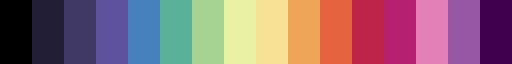

In [55]:
# Load colormap

# Read the colormap from a .txt file
def load_colormap_from_txt(file_path):
    # Load RGB values from the file
    rgb_values = np.loadtxt(file_path)
    return ListedColormap(rgb_values)

# Example usage
colormap_file = 'chase-spectral-rgb.txt'  # Replace with your .txt file path
radar_cmap = load_colormap_from_txt(colormap_file)

discrete_cmap = ListedColormap(radar_cmap(np.linspace(0, 1, 16)))
discrete_mask_cmap = discrete_cmap.copy()
discrete_mask_cmap.set_under(color='white') #set values below vmin to white
discrete_mask_cmap.set_bad(color='gray') #set missing (NaN) values to gray

discrete_mask_cmap

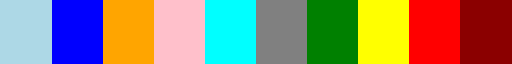

In [56]:
hid_cmap = colors.ListedColormap(['lightblue','blue','orange','pink','cyan','gray','green','yellow','red','darkred'])
hid_cmap.set_under(color='white') #set values below vmin to white
hid_cmap.set_bad(color='white') #set missing (NaN) values to gray

hid_cmap

Define time period of case study

In [3]:
#Define time period
time_map = np.datetime64('2024-08-29T17:30')
time_RHI = np.datetime64('2024-08-29T17:36')
az_RHI = 141.0

Open composite reflectivity

In [57]:
seapol = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4v1.2/PICCOLO_level4_composite_2D.nc')
seapol

<xarray.Dataset> Size: 109GB
Dimensions:       (time: 8706, Y: 491, X: 491)
Coordinates:
  * X             (X) float32 2kB -2.45e+05 -2.44e+05 ... 2.44e+05 2.45e+05
  * Y             (Y) float32 2kB -2.45e+05 -2.44e+05 ... 2.44e+05 2.45e+05
    latitude      (time, Y, X) float32 8GB ...
    longitude     (time, Y, X) float32 8GB ...
  * time          (time) datetime64[ns] 70kB 2024-08-16T08:10:00 ... 2024-09-...
Data variables: (12/15)
    HID_CSU       (time, Y, X) float32 8GB ...
    DBZ           (time, Y, X) float32 8GB ...
    KDP           (time, Y, X) float32 8GB ...
    PHIDP         (time, Y, X) float32 8GB ...
    RAINRATE      (time, Y, X) float32 8GB ...
    RHOHV         (time, Y, X) float32 8GB ...
    ...            ...
    WIDTH         (time, Y, X) float32 8GB ...
    ZDR           (time, Y, X) float32 8GB ...
    grid_mapping  int32 4B ...
    heading       (time) float32 35kB ...
    start_time    (time) datetime64[ns] 70kB ...
    stop_time     (time) datetime64[ns] 70kB ...
Attributes: (12/16)
    Conventions:       CF-1.12
    institution:       Colorado State University
    source:            CSU SEA-POL radar
    instrument:        SEA-POL
    title:             Level 4 Gridded SEA-POL Radar Data
    summary:           Level 4 Gridded SEA-POL Radar Data
    ...                ...
    platform:          RV METEOR
    keywords:          radar, precipitation, sea-pol
    processing_level:  Level 4
    license:           CC-BY-4.0
    scan_name:         PICCOLO_QVP
    history:           v1.2

RHI data

In [5]:
#Load data
rhi = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4v1.2/PICCOLO_level4_rhi_2D.nc')

#Find index
index_rhi = np.abs(pd.to_datetime(rhi.start_time) - time_RHI).argmin()


In [6]:
print('index_rhi:', index_rhi)
print('time at index_rhi:', rhi.start_time[index_rhi].values)
print('azimuth at index_rhi:', rhi.azimuth[index_rhi].values)

index_rhi: 1116
time at index_rhi: 2024-08-29T17:36:25.224000000
azimuth at index_rhi: 144.20558


In [7]:
rhi.azimuth[index_rhi-1:index_rhi+20].values

array([161.22066, 144.20558, 145.48549, 146.18312, 147.19661, 148.34743,
       149.44606, 150.45406, 151.30275, 152.18166, 153.25557, 154.3542 ,
       155.57918, 156.58992, 157.21614, 158.14449, 159.17995, 160.33351,
       161.23714, 162.25337, 163.08833], dtype=float32)

In [8]:
rhi.start_time[index_rhi-1:index_rhi+20].values

array(['2024-08-29T17:29:30.836999936', '2024-08-29T17:36:25.224000000',
       '2024-08-29T17:36:35.230000128', '2024-08-29T17:36:45.352000000',
       '2024-08-29T17:36:55.362999808', '2024-08-29T17:37:05.367000064',
       '2024-08-29T17:37:15.775000064', '2024-08-29T17:37:25.775000064',
       '2024-08-29T17:37:36.194999808', '2024-08-29T17:37:46.881999872',
       '2024-08-29T17:37:56.997999872', '2024-08-29T17:38:08.204000000',
       '2024-08-29T17:38:17.812000000', '2024-08-29T17:38:28.083000064',
       '2024-08-29T17:38:39.706000128', '2024-08-29T17:38:49.440000000',
       '2024-08-29T17:38:59.306999808', '2024-08-29T17:39:08.216999936',
       '2024-08-29T17:39:18.223000064', '2024-08-29T17:39:27.940000000',
       '2024-08-29T17:39:38.437999872'], dtype='datetime64[ns]')

In [24]:
#reset index_rhi to choose specific scan corresponding to az_rhi, if needed
index_rhi = 1129
print('index_rhi:', index_rhi)
print('time at index_rhi:', rhi.start_time[index_rhi].values)
print('azimuth at index_rhi:', rhi.azimuth[index_rhi].values)

index_rhi: 1129
time at index_rhi: 2024-08-29T17:38:39.706000128
azimuth at index_rhi: 157.21614


In [12]:
rhi

<xarray.Dataset> Size: 9GB
Dimensions:       (time: 5997, Z: 73, R: 481)
Coordinates:
  * R             (R) float32 2kB 0.0 250.0 500.0 ... 1.198e+05 1.2e+05
  * Z             (Z) float32 292B 0.0 250.0 500.0 ... 1.775e+04 1.8e+04
    latitude      (time, R) float32 12MB ...
    longitude     (time, R) float32 12MB ...
  * time          (time) datetime64[ns] 48kB 2024-08-16T14:25:00 ... 2024-09-...
Data variables: (12/15)
    HID_CSU       (time, Z, R) float32 842MB ...
    DBZ           (time, Z, R) float32 842MB ...
    KDP           (time, Z, R) float32 842MB ...
    PHIDP         (time, Z, R) float32 842MB ...
    RAINRATE      (time, Z, R) float32 842MB ...
    RHOHV         (time, Z, R) float32 842MB ...
    ...            ...
    WIDTH         (time, Z, R) float32 842MB ...
    ZDR           (time, Z, R) float32 842MB ...
    azimuth       (time) float32 24kB ...
    grid_mapping  int32 4B ...
    start_time    (time) datetime64[ns] 48kB 2024-08-16T14:27:30.877000192 .....
    stop_time     (time) datetime64[ns] 48kB ...
Attributes: (12/16)
    Conventions:       CF-1.12
    institution:       Colorado State University
    source:            CSU SEA-POL radar
    instrument:        SEA-POL
    title:             Level 4 Gridded SEA-POL Radar Data
    summary:           Level 4 Gridded SEA-POL Radar Data
    ...                ...
    platform:          RV METEOR
    keywords:          radar, precipitation, sea-pol
    processing_level:  Level 4
    license:           CC-BY-4.0
    NCO:               netCDF Operators version 4.9.7 (Homepage = http://nco....
    history:           Thu Dec 11 12:37:52 2025: ncrcat gridded_rhi_20240816_...

In [25]:
rhi_DBZ = rhi.DBZ[index_rhi, :, :]
rhi_ZDR = rhi.ZDR[index_rhi, :, :]
rhi_KDP = rhi.KDP[index_rhi, :, :]
rhi_HID = rhi.HID_CSU[index_rhi, :, :]

#Set missing data to NaN
rhi_DBZ = rhi_DBZ.where(rhi_DBZ != -9999, np.nan)
rhi_ZDR = rhi_ZDR.where(rhi_ZDR != -9999, np.nan)
rhi_KDP = rhi_KDP.where(rhi_KDP != -9999, np.nan)
rhi_HID = rhi_HID.where(rhi_HID != -9999, np.nan)

In [14]:
rhi_HID

<xarray.DataArray 'HID_CSU' (Z: 73, R: 481)> Size: 140kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(73, 481), dtype=float32)
Coordinates:
  * R          (R) float32 2kB 0.0 250.0 500.0 ... 1.195e+05 1.198e+05 1.2e+05
  * Z          (Z) float32 292B 0.0 250.0 500.0 ... 1.75e+04 1.775e+04 1.8e+04
    latitude   (R) float32 2kB 11.5 11.5 11.5 11.5 11.5 ... 11.5 11.5 11.5 11.5
    longitude  (R) float32 2kB -23.0 -23.0 -23.0 -23.0 ... -21.91 -21.91 -21.9
    time       datetime64[ns] 8B 2024-08-29T17:35:00
Attributes:
    grid_mapping:   grid_mapping
    valid_max:      3.4028e+38
    valid_min:      -3.4028e+38
    cell_methods:   time: mean
    long_name:      CSU Hydrometeor Identification
    standard_name:  HID_CSU
    units:          none

In [15]:
#Find indices
index_map = np.abs(pd.to_datetime(seapol.time) - time_map).argmin()
map = seapol.DBZ[index_map,:,:]

In [16]:
print('heading',seapol.heading[index_map].values)
print('start time',seapol.start_time[index_map].values)
print('stop time',seapol.stop_time[index_map].values)
print('center lat',seapol.latitude[index_map,245,245].values)
print('center_lon',seapol.longitude[index_map,245,245].values)

heading -90.90808
start time 2024-08-29T17:30:04.260000000
stop time 2024-08-29T17:36:16.027000064
center lat 11.498394
center_lon -22.97842


/tmp/ipykernel_1470227/2301627400.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(axs.get_xticklabels(), fontsize=18)
/tmp/ipykernel_1470227/2301627400.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_yticklabels(axs.get_yticklabels(), fontsize=18)


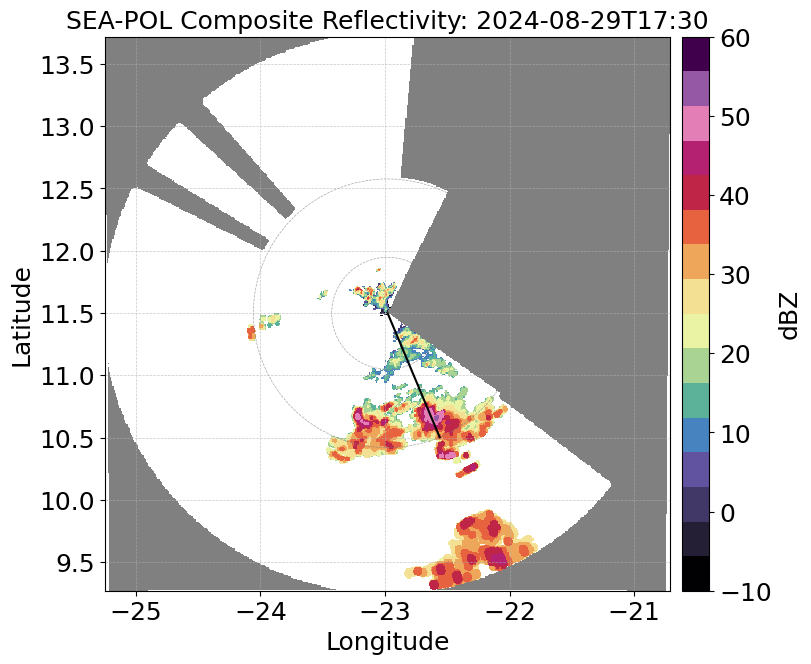

In [26]:
# Make plot
fig, axs = plt.subplots(figsize=(8, 8),layout="constrained")  

cax = axs.pcolormesh(map.longitude, map.latitude, map, cmap=discrete_mask_cmap, vmin=-10, vmax=60,shading='auto')
axs.set_aspect('equal',adjustable='box')
cbar = fig.colorbar(cax, ax=axs, orientation='vertical',pad=0.02, shrink=0.70)
cbar.ax.tick_params(labelsize=18)
cbar.set_ticks(np.linspace(-10,60,8))
cbar.ax.set_ylabel('dBZ', fontsize=18)

axs.set_title('SEA-POL Composite Reflectivity: ' + str(time_map),fontsize=18)    
axs.set_ylabel('Latitude', fontsize=18)
axs.set_xlabel('Longitude',fontsize=18)
#axs.set_xlim([-60, -59])
#axs.set_ylim([12.5, 13.5])
#axs.set_xticks(np.linspace(-31,-27, 5))  # Adjust the number of ticks as needed
#axs.set_yticks(np.linspace(10, 14, 5))  # Adjust the number of ticks as needed
axs.set_xticklabels(axs.get_xticklabels(), fontsize=18)
axs.set_yticklabels(axs.get_yticklabels(), fontsize=18)

# Add grid lines to the first subplot
axs.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add 120 km circle
axs.add_patch(plt.Circle((map.longitude[245,245], map.latitude[245,245]), 120/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))

# Add 50 km circle
axs.add_patch(plt.Circle((map.longitude[245,245], map.latitude[245,245]), 50/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))

# Add azimuth line
# Radar center (latitude and longitude)
center_lat = map.latitude[245, 245]  # Replace with the radar's latitude
center_lon = map.longitude[245, 245]  # Replace with the radar's longitude

# Define the radius of the line (e.g., 120 km)
radius_km = 120
radius_deg = radius_km / 111.32  # Convert km to degrees (approximation)

# Azimuth in degrees
azimuth = rhi.azimuth[index_rhi].values

# Calculate the endpoint of the line
end_lat = center_lat + radius_deg * np.cos(np.radians(azimuth))
end_lon = center_lon + radius_deg * np.sin(np.radians(azimuth))

# Draw the line
axs.plot([center_lon, end_lon], [center_lat, end_lat], color='black', linestyle='-', linewidth=1.5)


# Make plot

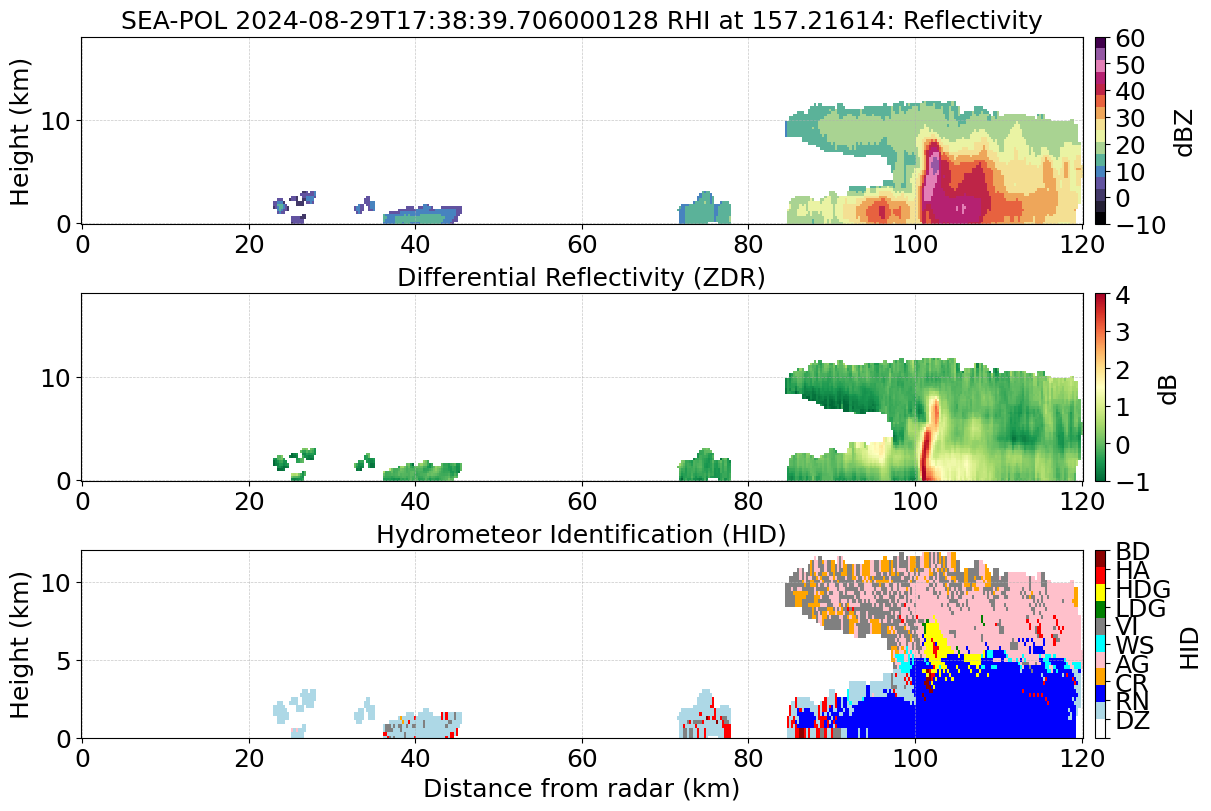

In [53]:
fig, axs = plt.subplots(3,1, figsize=(12, 8),layout="constrained")  # 3 rows, 1 column

#RHI dBZ
cax = axs[0].pcolormesh(rhi.R/1000, rhi.Z/1000, rhi_DBZ, cmap=discrete_cmap, vmin=-10, vmax=60,shading='auto')
cbar = fig.colorbar(cax, ax=axs[0], orientation='vertical',pad=-0.01)
cbar.ax.tick_params(labelsize=18)
cbar.set_ticks(np.linspace(-10,60,8))
cbar.ax.set_ylabel('dBZ', fontsize=18)

#axs[0].set_ylim(0,12)
axs[0].set_title('SEA-POL '+str(rhi.start_time[index_rhi].values)+' RHI at '+str(rhi.azimuth[index_rhi].values)+': Reflectivity',fontsize=18)   
axs[0].set_ylabel('Height (km)', fontsize=18)
#axs[0].set_xlabel('Distance from radar (km)',fontsize=18)
axs[0].tick_params(axis='both',labelsize=18)
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

#RHI ZDR
cax1 = axs[1].pcolormesh(rhi.R/1000, rhi.Z/1000, rhi_ZDR, cmap='RdYlGn_r', vmin = -1, vmax = 4, shading='auto')
cbar1 = fig.colorbar(cax1, ax=axs[1], orientation='vertical',pad=-0.01)
cbar1.ax.tick_params(labelsize=18)
cbar1.set_ticks(np.linspace(-1,4,6))
#cbar1.ax.set_ylabel('Deg/km', fontsize=18)
cbar1.ax.set_ylabel('dB', fontsize=18)

axs[1].set_title('Differential Reflectivity (ZDR)',fontsize=18)
axs[1].tick_params(axis='both',labelsize=18)
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

#RHI HID
cax2 = axs[2].pcolormesh(rhi.R/1000, rhi.Z/1000, rhi_HID, cmap=hid_cmap, vmin = 1, vmax = 10, shading='auto')
cbar2 = fig.colorbar(cax2, ax=axs[2], orientation='vertical',pad=-0.01)
cbar2.ax.tick_params(labelsize=18)
cbar2.set_ticks(np.linspace(0,10,11))
cbar2.set_ticklabels(['','DZ','RN','CR','AG','WS','VI','LDG','HDG','HA','BD'])
cbar2.ax.set_ylabel('HID', fontsize=18)

axs[2].set_ylim(0,12)
axs[2].set_title('Hydrometeor Identification (HID)',fontsize=18)   
axs[2].set_ylabel('Height (km)', fontsize=18)
axs[2].set_xlabel('Distance from radar (km)',fontsize=18)
axs[2].tick_params(axis='both',labelsize=18)
axs[2].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)


Text(0.5, 1.0, 'Histogram of Hydrometeor Identification (HID) Categories')

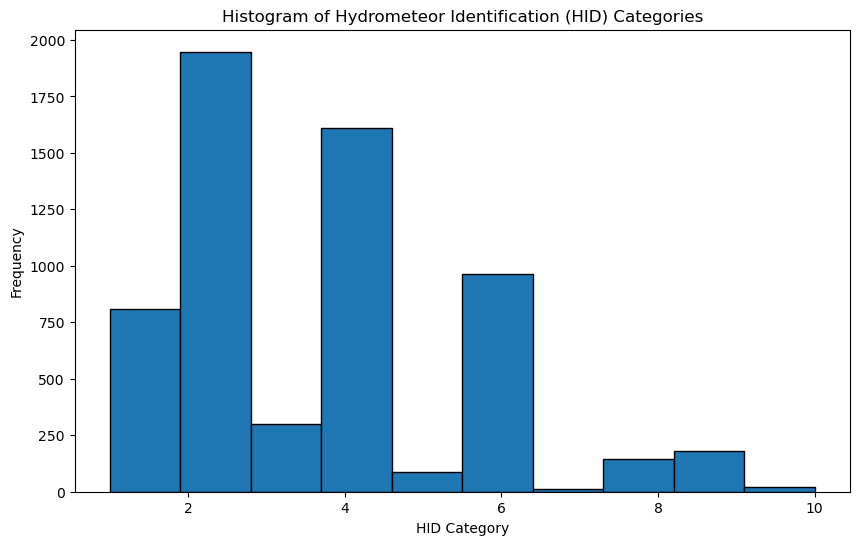

In [28]:
# plot histogram of HID
plt.figure(figsize=(10, 6))
plt.hist(rhi_HID.values.flatten(),edgecolor='black')
plt.xlabel('HID Category')
plt.ylabel('Frequency')
plt.title('Histogram of Hydrometeor Identification (HID) Categories')

In [33]:
rhi_HID.values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(73, 481), dtype=float32)